2539.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
=== Phase 1 Training: Smaller Images + Mixup ===


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


Epoch 1/5: Train Loss 1.0574, Train Acc 0.4518 | Val Loss 1.0162, Val Acc 0.8667


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


Epoch 2/5: Train Loss 0.9123, Train Acc 0.6835 | Val Loss 0.8407, Val Acc 0.6000


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


Epoch 3/5: Train Loss 0.6422, Train Acc 0.8464 | Val Loss 0.6798, Val Acc 0.8000


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch 4/5: Train Loss 0.6151, Train Acc 0.8543 | Val Loss 0.6356, Val Acc 0.8667


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Epoch 5/5: Train Loss 0.6009, Train Acc 0.8522 | Val Loss 0.6928, Val Acc 0.8000
=== Phase 2 Training: Full Resolution Fine-tuning ===


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]

Epoch 1/1: Train Loss 0.4649, Train Acc 0.9332 | Val Loss 0.5784, Val Acc 0.8000


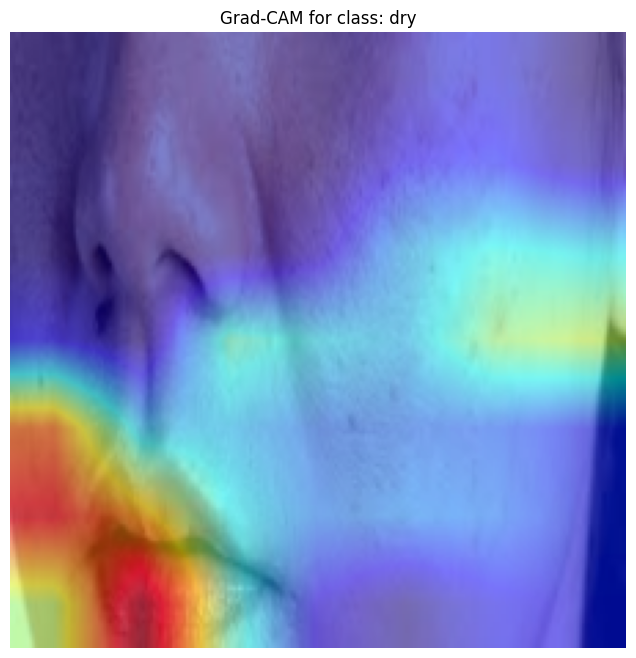

In [ ]:
# skin_type_classifier.ipynb

# %%
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# For Grad-CAM
!pip install -q grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# %%
# Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 3
batch_size = 32
num_epochs_phase1 = 5   # smaller images
num_epochs_phase2 = 1   # full res fine-tuning
mixup_alpha = 0.4
label_smoothing = 0.1

# Paths - Adjust these to your dataset folders
data_dir = "./odata"

# %%
# Mixup Collate Function
def mixup_collate(batch, alpha=mixup_alpha):
    inputs, targets = zip(*batch)
    inputs = torch.stack(inputs)
    targets = torch.tensor(targets)

    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(inputs.size(0))

    mixed_inputs = lam * inputs + (1 - lam) * inputs[index, :]
    targets_a, targets_b = targets, targets[index]

    return mixed_inputs, (targets_a, targets_b, lam)

# %%
# Transforms for progressive resizing

# Phase 1: smaller images
transform_phase1 = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Phase 2: full resolution
transform_phase2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# %%
# Load Datasets with Phase 1 transform initially

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_phase1)
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=transform_phase2)  # validation at full res

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=mixup_collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# %%
# Build Model: ConvNeXt-Base with classifier head replaced

from torchvision.models import convnext_base, ConvNeXt_Base_Weights

weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
model = convnext_base(weights=weights)

model.classifier[2] = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier[2].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)

model = model.to(device)

# %%
# Criterion with label smoothing (only use label smoothing if not using mixup)
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# %%
# Training and Validation Functions

def train_epoch(model, loader, optimizer, criterion, device, use_mixup=True):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(loader):
        inputs = inputs.to(device)
        if use_mixup:
            targets_a, targets_b, lam = targets
            targets_a = targets_a.to(device)
            targets_b = targets_b.to(device)
        else:
            targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        if use_mixup:
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            preds = outputs.argmax(dim=1)
            # For accuracy count, pick predictions matching either label_a or label_b weighted by lam
            correct += (lam * preds.eq(targets_a).sum() + (1 - lam) * preds.eq(targets_b).sum()).item()
            total += inputs.size(0)
        else:
            loss = criterion(outputs, targets)
            preds = outputs.argmax(dim=1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * inputs.size(0)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# %%
# Phase 1 Training: smaller images + mixup enabled

print("=== Phase 1 Training: Smaller Images + Mixup ===")
for epoch in range(num_epochs_phase1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, use_mixup=True)
    val_loss, val_acc = validate_epoch(model, valid_loader, criterion, device)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_phase1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

# %%
# Switch to Phase 2: full resolution, no mixup (label smoothing on)
# Update transforms for training dataset

train_dataset.transform = transform_phase2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("=== Phase 2 Training: Full Resolution Fine-tuning ===")
for epoch in range(num_epochs_phase2):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, use_mixup=False)
    val_loss, val_acc = validate_epoch(model, valid_loader, criterion, device)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_phase2}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

# %%
# Save final model
torch.save(model.state_dict(), "skin_type_convnext_base.pth")

# %%
# Grad-CAM Visualization Helper

def visualize_gradcam(model, image_tensor, label, class_names):
    model.eval()
    rgb_img = image_tensor.permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())  # normalize

    target_layer = model.features[-1]
    targets = [ClassifierOutputTarget(label)]

    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0).to(device), targets=targets)[0]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(8, 8))
    plt.title(f"Grad-CAM for class: {class_names[label]}")
    plt.axis('off')
    plt.imshow(visualization)
    plt.show()

# %%
# Example Grad-CAM usage on a validation sample

class_names = train_dataset.classes
model.eval()

# Pick one sample from validation set
sample_img, sample_label = valid_dataset[0]

visualize_gradcam(model, sample_img, sample_label, class_names)


In [4]:
# %%
import os
import torch
from torchvision import transforms, models, datasets
from PIL import Image
import matplotlib.pyplot as plt

# %%
# Device and config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 3
class_names = ['dry', 'normal', 'oily']  # adjust if your folder order is different

# %%
# Load model
from torchvision.models import convnext_base, ConvNeXt_Base_Weights

weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
model = convnext_base(weights=weights)

model.classifier[2] = torch.nn.Sequential(
    torch.nn.Dropout(0.4),
    torch.nn.Linear(model.classifier[2].in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(256, num_classes)
)
model.load_state_dict(torch.load("skin_type_convnext_base.pth", map_location=device))
model = model.to(device)
model.eval()

# %%
# Transformation (must match training time full-res)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# %%
# Prediction function
from glob import glob

def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred_class = class_names[probs.argmax()]
        return pred_class, probs

# %%
# Predict on all test images in folder
test_root = "odata/test"
image_extensions = ('.png', '.jpg', '.jpeg')
results = []

for label in class_names:
    folder = os.path.join(test_root, label)
    image_paths = [os.path.join(folder, fname) for fname in os.listdir(folder) if fname.lower().endswith(image_extensions)]
    
    for img_path in image_paths:
        pred_label, probs = predict_image(img_path)
        results.append((img_path, label, pred_label, probs))

# %%
# Display sample predictions
for img_path, true_label, pred_label, probs in results[:40]:
    print(f"Image: {img_path}")
    print(f"True: {true_label} | Predicted: {pred_label} | Probabilities: {probs}")
    print("-----")

# Optional: plot one example
img_path, _, pred_label, probs = results[0]
img = Image.open(img_path)
plt.imshow(img)
plt.title(f"Predicted: {pred_label}")
plt.axis('off')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'skin_type_convnext_base.pth'

In [2]:
pip install torch torchvision matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install torchsummary torchviz


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
